In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scanpy as sc

from pathlib import Path

from abc_atlas_access.abc_atlas_cache.abc_project_cache import AbcProjectCache      # install this via 'pip install -U git+https://github.com/alleninstitute/abc_atlas_access'

In [52]:
download_base = Path('./Zhuang')        # The local directory to which data files will be downloaded
abc_cache = AbcProjectCache.from_cache_dir(download_base)

dataset = 'Zhuang-ABCA-1'

# Retrieves cell metadata file; downloads if not in local directory
cells = abc_cache.get_metadata_dataframe(directory=dataset, file_name='cell_metadata', dtype={'cell_label': str})
cells.set_index('cell_label', inplace=True)

# Retrieves CCF coordinates for the cells; downloads if not in local directory
ccf_coordinates = abc_cache.get_metadata_dataframe(directory=f'{dataset}-CCF', file_name='ccf_coordinates')
ccf_coordinates.set_index('cell_label', inplace=True)
ccf_coordinates.rename(columns={'x': 'CCF_x', 'y': 'CCF_y', 'z': 'CCF_z'}, inplace=True)

# Appends CCF coordinates to the cell metadata
cells = cells.join(ccf_coordinates, how='inner').rename(columns={'x_ccf': 'CCF_x', 'y_ccf': 'CCF_y', 'z_ccf': 'CCF_z', 'parcellation_index': 'CCF_parcellation_index'})
cells['y'] = -cells['y']

# Retrieves parcellation information; downloads if not in local directory
parcellation_annotation = abc_cache.get_metadata_dataframe(directory='Allen-CCF-2020', file_name='parcellation_to_parcellation_term_membership')

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/abc_atlas_access/abc_atlas_cache/cloud_cache.py:630: OutdatedManifestWarning: You are loading releases/20241130/manifest.json. A more up to date version of the dataset -- releases/20250331/manifest.json -- exists online. To see the changes between the two versions of the dataset, run
type.compare_manifests('releases/20241130/manifest.json', 'releases/20250331/manifest.json')
To load another version of the dataset, run
type.load_manifest('releases/20250331/manifest.json')
  warnings.warn(msg, OutdatedManifestWarning)


In [74]:
# Which slice (anterior-posterior) to extract
som_slice = 1.058
aud_slice = 1.086       

som_cells = cells[cells['brain_section_label'] == 'Zhuang-ABCA-'+str(som_slice)]
aud_cells = cells[cells['brain_section_label'] == 'Zhuang-ABCA-'+str(aud_slice)]
'''
Each parcellation term corresponds to an 'order' in the parcellation hierarchy, where higher-order terms are more specific subsets of lower-order terms
The dictionary maps each region of interest to a string portion of its parcellation term name, as well as the order in which to look for that name.
'''
name_map = {'Isocortex': ['isocortex', 2],
            'SOM': ['somatosensory', 3],
            'AUD': ['auditory', 3],
            'layer 1': ['layer 1', 4],
            'layer 2/3': ['layer 2/3', 4],
            'layer 4': ['layer 4', 4],
            'layer 5': ['layer 5', 4],
            'layer 6': ['layer 6', 4],}

som_cells_by_regions = pd.DataFrame(index=som_cells.index, columns=name_map.keys()).fillna(False)
aud_cells_by_regions = pd.DataFrame(index=aud_cells.index, columns=name_map.keys()).fillna(False)

# Iterates through each cell and each region, and identifies if the cell's parcellation index falls under the region's parcellation ancestry
for cell in som_cells.index:
    for region, [search, order] in name_map.items():
        som_cells_by_regions.loc[cell, region] = search in list(parcellation_annotation[parcellation_annotation['parcellation_index'] == som_cells.loc[cell, 'CCF_parcellation_index']]['parcellation_term_name'])[order].lower()

for cell in aud_cells.index:
    for region, [search, order] in name_map.items():
        aud_cells_by_regions.loc[cell, region] = search in list(parcellation_annotation[parcellation_annotation['parcellation_index'] == aud_cells.loc[cell, 'CCF_parcellation_index']]['parcellation_term_name'])[order].lower()

In [75]:
# Functions to determine lateral borders of columns, and to extract layer identities of columnar cells

def leftFunc(x, borders):
    [[x1, x2], [y1, y2]] = borders[0]
    return (y1 - y2) / (x1 - x2) * (x - x1) + y1

def rightFunc(x, borders):
    [[x1, x2], [y1, y2]] = borders[1]
    return (y1 - y2) / (x1 - x2) * (x - x1) + y1

def cells_of(cells, cells_by_regions, region):
    return cells[cells.index.isin(cells_by_regions[cells_by_regions[region] == True].index)]

1237 Isocortex
149 layer 1
331 layer 2/3
275 layer 4
190 layer 5
441 layer 6


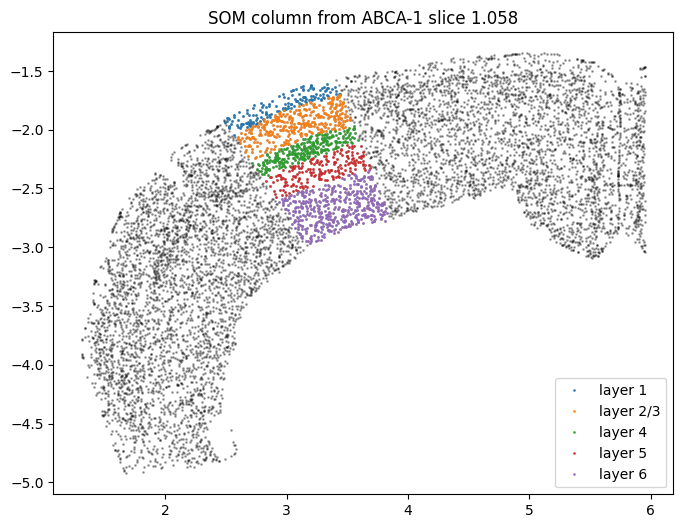

1012 Isocortex
114 layer 1
319 layer 2/3
118 layer 4
357 layer 5
218 layer 6


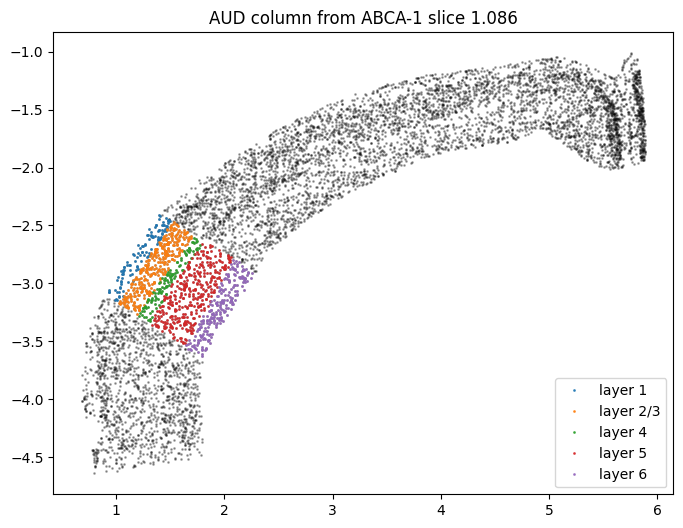

In [102]:
# SOM 1.058

ROIs = ['layer 1', 'layer 2/3', 'layer 4', 'layer 5', 'layer 6']

isocortex = som_cells[som_cells.index.isin(som_cells_by_regions[som_cells_by_regions['Isocortex'] == True].index)]

som_borders = np.array([[[3.163749883786499, 2.481411543681871], 
                         [-2.984381204079216, -1.920129826905108]],
                         
                         [[3.846496599697873, 3.402327776942732],
                          [-2.7383452452886643, -1.5781737284616928]]])

fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(isocortex['x'], isocortex['y'], 'ok', ms=1, alpha=0.3)

iso_no_l1 = som_cells[som_cells.index.isin(som_cells_by_regions[(som_cells_by_regions['Isocortex'] == True) & (som_cells_by_regions['layer 1'] == False)].index)]
column = iso_no_l1[(iso_no_l1['y'] > leftFunc(iso_no_l1['x'], som_borders)) & (iso_no_l1['y'] < rightFunc(iso_no_l1['x'], som_borders))]
print(len(column), 'Isocortex')

for roi in ROIs:
    region = cells_of(som_cells, som_cells_by_regions, roi)
    column = region[(region['y'] > leftFunc(region['x'], som_borders)) & (region['y'] < rightFunc(region['x'], som_borders))]
    print(len(column), roi)
    if roi != 'Isocortex':
        ax.plot(column['x'], column['y'], 'o', ms=1, alpha=0.8, label=roi)

ax.set_title('SOM column from ABCA-1 slice 1.058')
ax.legend(loc='lower right')
plt.show()


# AUD 1.086
isocortex = cells_of(aud_cells, aud_cells_by_regions, 'Isocortex')

aud_borders = np.array([[[1.717909340172061, 0.9769986684873154], 
                         [-3.5999627839161072, -3.1419191851206696]], 
                         
                         [[2.273093619530997, 1.425606086259224], 
                          [-2.892298527286825, -2.410579404049322]]])

fig, ax = plt.subplots(figsize=(8, 6))

ax.plot(isocortex['x'], isocortex['y'], 'ok', ms=1, alpha=0.3)

iso_no_l1 = aud_cells[aud_cells.index.isin(aud_cells_by_regions[(aud_cells_by_regions['Isocortex'] == True) & (aud_cells_by_regions['layer 1'] == False)].index)]
column = iso_no_l1[(iso_no_l1['y'] > leftFunc(iso_no_l1['x'], aud_borders)) & (iso_no_l1['y'] < rightFunc(iso_no_l1['x'], aud_borders))]
print(len(column), 'Isocortex')

for roi in ROIs:
    region = cells_of(aud_cells, aud_cells_by_regions, roi)
    column = region[(region['y'] > leftFunc(region['x'], aud_borders)) & (region['y'] < rightFunc(region['x'], aud_borders))]
    print(len(column), roi)
    if roi != 'Isocortex':
        ax.plot(column['x'], column['y'], 'o', ms=1, alpha=0.8, label=roi)

ax.set_title('AUD column from ABCA-1 slice 1.086')
ax.legend(loc='lower right')
plt.show()
